# Setup

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy matplotlib

In [2]:
import os
import configparser
import random

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat, savemat
from scipy.signal import decimate, resample

In [3]:
config = configparser.ConfigParser()
config.read('../../config.ini')

['../../config.ini']

In [5]:
PROJECT_DIR = config.get('PATHS', 'PROJECT_PATH')
PAIRED_DATA_DIR = os.path.join(PROJECT_DIR, 'data/paired2')
PAIRED_TRAIN_DIR = os.path.join(PAIRED_DATA_DIR, 'train')
PAIRED_VALID_DIR = os.path.join(PAIRED_DATA_DIR, 'validation')
INTERIM_MECG_DATA_DIR = os.path.join(PROJECT_DIR, 'data/interim/mecg')
INTERIM_FECG_DATA_DIR = os.path.join(PROJECT_DIR, 'data/interim/fecg')

SYNDB_FECG_DIR = os.path.join(INTERIM_FECG_DATA_DIR, 'fecgsyndb-1.0.0')
SYNDB_MECG_DIR = os.path.join(INTERIM_MECG_DATA_DIR, 'fecgsyndb-1.0.0')
BIDMC_MECG_DIR = os.path.join(INTERIM_MECG_DATA_DIR, 'bidmc-1.0.0')
FANTASIA_MECG_DIR = os.path.join(INTERIM_MECG_DATA_DIR, 'fantasia-1.0.0')
NSRDB_MECG_DIR = os.path.join(INTERIM_MECG_DATA_DIR, 'nsrdb-1.0.0')
STDB_MECG_DIR = os.path.join(INTERIM_MECG_DATA_DIR, 'stdb-1.0.0')

os.makedirs(PAIRED_DATA_DIR, exist_ok=True)
os.makedirs(PAIRED_TRAIN_DIR, exist_ok=True)
os.makedirs(PAIRED_VALID_DIR, exist_ok=True)

TOTAL_FILES = 40000
TARGET_FS = 125

In [6]:
SIGNAL_KEYS = ('filtered', 'light', 'raw')

def downsample(curr_freq : int, signal : np.ndarray, target_freq = 125, axis : int = 0) -> np.ndarray: 
    '''Downsamples signal at curr_freq to target_freq '''
    if curr_freq % target_freq: # if need .resample 
        target_samples = int(signal.shape[axis] / curr_freq * target_freq)
        return resample(signal, target_samples, axis=axis)
        
    return decimate(signal, int(curr_freq / target_freq), axis=axis)

def load_file(filename):
    d = loadmat(filename)
    fs = d['fs'][0][0]
    
    for k in SIGNAL_KEYS:
        if k in d:
            shape = d[k].shape
            d[k] = downsample(fs, d[k], target_freq=125, axis=0 if shape[0] > shape[1] else 1)
    if 'peaks' in d:
        d['peaks'] = np.rint(d['peaks'][0] * TARGET_FS / fs).astype('int64')
    
    return d

# SYNDB

In [6]:
sample_fecg = load_file(os.path.join(SYNDB_FECG_DIR, 'sub01_snr03dB_l1_c4_fecg1'))
sample_mecg = load_file(os.path.join(SYNDB_MECG_DIR, 'sub01_snr03dB_l1_c4_mecg'))
indices = sample_fecg['peaks'][0]

0
0
0
0


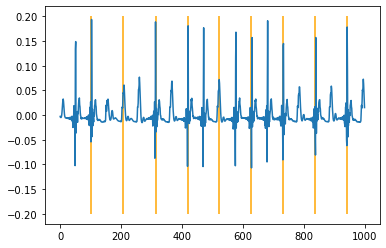

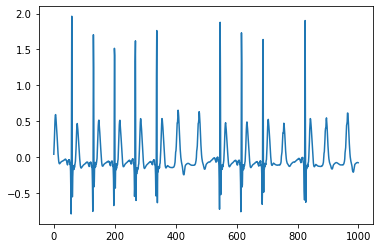

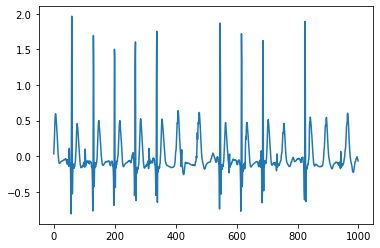

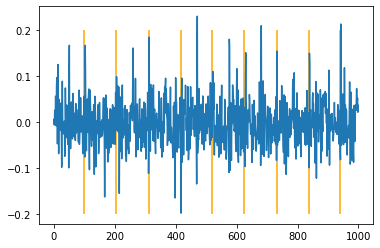

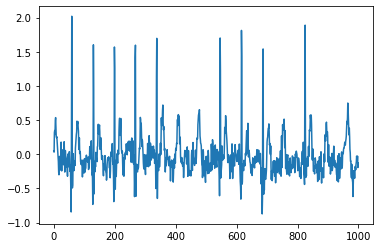

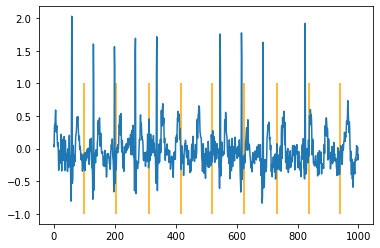

In [7]:
plt.vlines([ind for ind in indices if ind < 1000], -.2, .2, color='orange')
plt.plot(sample_fecg['filtered'][:1000,0])
plt.show()
plt.plot(sample_mecg['filtered'][:1000,0])
plt.show()
plt.plot(sample_fecg['filtered'][:1000,0]+sample_mecg['filtered'][:1000,0])
plt.show()
plt.vlines([ind for ind in indices if ind < 1000], -.2, .2, color='orange')
plt.plot(sample_fecg['raw'][:1000,0])
plt.show()
plt.plot(sample_mecg['raw'][:1000,0])
plt.show()
plt.vlines([ind for ind in indices if ind < 1000], -1, 1, color='orange')
plt.plot(sample_fecg['raw'][:1000,0]+sample_mecg['raw'][:1000,0])
plt.show()

In [7]:
def get_fetal_filenames_syndb(data_dir : str = SYNDB_FECG_DIR) -> np.ndarray:
    '''returns a 10 (patients) x 5 (snr levels) x y (physiological levels, status) x 5 (repetition) x 75000 (250 Hz x 5 min) x 34 (channels)'''
    x1 = []
    for patient in range(1,11): # patient number
        x2 = []
        for snr in range(5): # noise level
            x3 = []
            for rep in range(1, 6):
                x4 = [[os.path.join(data_dir, f'sub{patient:02}_snr{snr*3:02}dB_l{rep}_fecg1')], [os.path.join(data_dir, f'sub{patient:02}_snr{snr*3:02}dB_l{rep}_c5_fecg1'), os.path.join(data_dir, f'sub{patient:02}_snr{snr*3:02}dB_l{rep}_c5_fecg2')]]
                
                for case in range(5):
                    x4.append([os.path.join(data_dir, f'sub{patient:02}_snr{snr*3:02}dB_l{rep}_c{case}_fecg1')])
                
                x3.append(x4) 
            x2.append(x3)
        x1.append(x2)

    return np.array(x1, dtype = object)

In [8]:
def get_maternal_filenames_syndb(data_dir : str = SYNDB_MECG_DIR) -> np.ndarray:
    '''returns a 10 (patients) x 5 (snr levels) x y (physiological levels, status) x 5 (repetition) x 75000 (250 Hz x 5 min) x 34 (channels)'''
    x1 = []
    for patient in range(1,11): # patient number
        x2 = []
        for snr in range(5): # noise level
            x3 = []
            for rep in range(1, 6):
                x4 = [os.path.join(data_dir, f'sub{patient:02}_snr{snr*3:02}dB_l{rep}_mecg')]
                for case in range(6):
                    x4.append(os.path.join(data_dir, f'sub{patient:02}_snr{snr*3:02}dB_l{rep}_c{case}_mecg'))
                x3.append(x4)
                          
            x2.append(x3)

        x1.append(x2)

    return np.array(x1, dtype = object)

In [9]:
fetal_filenames = get_fetal_filenames_syndb()
maternal_filenames = get_maternal_filenames_syndb()

In [105]:
def save_paired_syndb(fetal_filenames, maternal_filenames):
    for i in range(fetal_filenames.shape[0]):
        print(f'Subject {i}')
        for j in range(1, fetal_filenames.shape[1]): #only use SNR > 0
            print(f'SNR index {j}')
            for k in range(fetal_filenames.shape[2]):
                for l in range(len(fetal_filenames[i][j][k])):
                    if i < 3:
                        directory = PAIRED_VALID_DIR
                    else:
                        directory = PAIRED_TRAIN_DIR
                    f_name = fetal_filenames[i][j][k][l][0]
                    m_name = maternal_filenames[i][j][k][l]
                    fd = load_file(f_name)
                    md = load_file(m_name)
                    for c in range(fd['raw'].shape[0]):
                        interval_start = random.randrange(fd['raw'].shape[1] - 500)
                        d = {
                            'fecg_signal': fd['raw'][c,interval_start:interval_start+500],
                            'fecg_clean': fd['filtered'][c,interval_start:interval_start+500],
                            'mecg_signal': md['raw'][c,interval_start:interval_start+500],
                            'mecg_clean': md['filtered'][c,interval_start:interval_start+500],
                            'fecg_peaks': [p - interval_start for p in fd['peaks'].flatten() if p >= interval_start and p < interval_start + 500],
                            'fecg_interval_start': interval_start,
                            'mecg_interval_start': interval_start,
                            'fecg_file': f_name,
                            'mecg_file': m_name
                        }
                        savemat(file_name=os.path.join(directory, f'syndb_{i}_{j}_{k}_{l}_{c}'), mdict=d)

In [ ]:
save_paired_syndb(fetal_filenames, maternal_filenames)

Subject 0
SNR index 1
SNR index 3
SNR index 4
Subject 1
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Subject 2
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Subject 3
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Subject 4
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Subject 5
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Subject 6
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Subject 7
SNR index 1


# BIDMC

In [16]:
def get_maternal_filenames_bidmc(data_dir : str = BIDMC_MECG_DIR) -> np.ndarray:
    return np.array([os.path.join(data_dir, x) for x in os.listdir(data_dir) if 'bidmc' in x])

In [17]:
maternal_filenames = get_maternal_filenames_bidmc()
validation_maternal_filenames = maternal_filenames[:maternal_filenames.shape[0]//5]
train_maternal_filenames = maternal_filenames[maternal_filenames.shape[0]//5:]

In [18]:
def save_paired_bidmc(fetal_filenames, train_maternal_filenames, validation_maternal_filenames):
    train_counts = np.array([0] * train_maternal_filenames.shape[0])
    valid_counts = np.array([0] * validation_maternal_filenames.shape[0])
    train_minimum = 0
    valid_minimum = 0
    for i in range(fetal_filenames.shape[0]):
        print('Train counts:', train_counts)
        print('Validation counts:', valid_counts)
        print('Subject', i)
        for j in range(1, fetal_filenames.shape[1]): #only use SNR > 0
            print('SNR index', j)
            for k in range(fetal_filenames.shape[2]):
                for l in range(len(fetal_filenames[i][j][k])):
                    if i < 3:
                        output_directory = PAIRED_VALID_DIR
                        cands = np.where(valid_counts == valid_minimum)
                        if cands[0].shape[0] == 0:
                            valid_minimum += 1
                            cands = np.where(valid_counts == valid_minimum)
                        m_ind = np.random.choice(cands[0])
                        valid_counts[m_ind] += 1
                        m_name = validation_maternal_filenames[m_ind]
                    else:
                        output_directory = PAIRED_TRAIN_DIR
                        cands = np.where(train_counts == train_minimum)
                        if cands[0].shape[0] == 0:
                            train_minimum += 1
                            cands = np.where(train_counts == train_minimum)
                        m_ind = np.random.choice(cands[0])
                        train_counts[m_ind] += 1
                        m_name = train_maternal_filenames[m_ind]
                    f_name = fetal_filenames[i][j][k][l][0]
                    fd = load_file(f_name)
                    md = load_file(m_name)
                    for c in range(fd['raw'].shape[0]):
                        fecg_interval_start = random.randrange(fd['raw'].shape[1] - 500)
                        mecg_interval_start = random.randrange(md['light'].shape[1] - 500)
                        d = {
                            'fecg_signal': fd['raw'][c,fecg_interval_start:fecg_interval_start+500],
                            'fecg_clean': fd['filtered'][c,fecg_interval_start:fecg_interval_start+500],
                            'mecg_signal': md['light'][0,mecg_interval_start:mecg_interval_start+500],
                            'mecg_clean': md['filtered'][0,mecg_interval_start:mecg_interval_start+500],
                            'fecg_peaks': [p - fecg_interval_start for p in fd['peaks'].flatten() if p >= fecg_interval_start and p < fecg_interval_start + 500],
                            'fecg_interval_start': fecg_interval_start,
                            'mecg_interval_start': mecg_interval_start,
                            'fecg_file': f_name,
                            'mecg_file': m_name
                        }
                        savemat(file_name=os.path.join(output_directory, f'bidmc_{i}_{j}_{k}_{l}_{c}'), mdict=d)

In [ ]:
save_paired_bidmc(fetal_filenames, train_maternal_filenames, validation_maternal_filenames)

# Fantasia

In [19]:
def get_maternal_filenames_fantasia(data_dir : str = FANTASIA_MECG_DIR) -> np.ndarray:
    return np.array([os.path.join(data_dir, x) for x in os.listdir(data_dir) if 'f' in x])

In [20]:
maternal_filenames = get_maternal_filenames_fantasia()
validation_maternal_filenames = maternal_filenames[:maternal_filenames.shape[0]//5]
train_maternal_filenames = maternal_filenames[maternal_filenames.shape[0]//5:]

In [21]:
def save_paired_fantasia(fetal_filenames, train_maternal_filenames, validation_maternal_filenames):
    train_counts = np.array([0] * train_maternal_filenames.shape[0])
    valid_counts = np.array([0] * validation_maternal_filenames.shape[0])
    train_minimum = 0
    valid_minimum = 0
    for i in range(fetal_filenames.shape[0]):
        print('Train counts:', train_counts)
        print('Validation counts:', valid_counts)
        print('Subject', i)
        for j in range(1, fetal_filenames.shape[1]): #only use SNR > 0
            print('SNR index', j)
            for k in range(fetal_filenames.shape[2]):
                for l in range(len(fetal_filenames[i][j][k])):
                    if i < 3:
                        output_directory = PAIRED_VALID_DIR
                        cands = np.where(valid_counts == valid_minimum)
                        if cands[0].shape[0] == 0:
                            valid_minimum += 1
                            cands = np.where(valid_counts == valid_minimum)
                        m_ind = np.random.choice(cands[0])
                        valid_counts[m_ind] += 1
                        m_name = validation_maternal_filenames[m_ind]
                    else:
                        output_directory = PAIRED_TRAIN_DIR
                        cands = np.where(train_counts == train_minimum)
                        if cands[0].shape[0] == 0:
                            train_minimum += 1
                            cands = np.where(train_counts == train_minimum)
                        m_ind = np.random.choice(cands[0])
                        train_counts[m_ind] += 1
                        m_name = train_maternal_filenames[m_ind]
                    f_name = fetal_filenames[i][j][k][l][0]
                    fd = load_file(f_name)
                    md = load_file(m_name)
                    for c in range(fd['raw'].shape[0]):
                        fecg_interval_start = random.randrange(fd['raw'].shape[1] - 500)
                        mecg_interval_start = random.randrange(md['raw'].shape[1] - 500)
                        d = {
                            'fecg_signal': fd['raw'][c,fecg_interval_start:fecg_interval_start+500],
                            'fecg_clean': fd['filtered'][c,fecg_interval_start:fecg_interval_start+500],
                            'mecg_signal': md['light'][0,mecg_interval_start:mecg_interval_start+500],
                            'mecg_clean': md['filtered'][0,mecg_interval_start:mecg_interval_start+500],
                            'fecg_peaks': [p - fecg_interval_start for p in fd['peaks'].flatten() if p >= fecg_interval_start and p < fecg_interval_start + 500],
                            'fecg_interval_start': fecg_interval_start,
                            'mecg_interval_start': mecg_interval_start,
                            'fecg_file': f_name,
                            'mecg_file': m_name
                        }
                        savemat(file_name=os.path.join(output_directory, f'fantasia_{i}_{j}_{k}_{l}_{c}'), mdict=d)

In [22]:
save_paired_fantasia(fetal_filenames, train_maternal_filenames, validation_maternal_filenames)

Train counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Validation counts: [0 0 0 0 0 0 0]
Subject 0
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Train counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Validation counts: [20 20 20 20 20 20 20]
Subject 1
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Train counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Validation counts: [40 40 40 40 40 40 40]
Subject 2
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Train counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Validation counts: [60 60 60 60 60 60 60]
Subject 3
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Train counts: [4 5 5 4 4 5 5 5 5 5 5 4 5 4 4 5 5 5 4 4 4 5 5 5 5 4 5 5 5 5]
Validation counts: [60 60 60 60 60 60 60]
Subject 4
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Train counts: [ 9  9  9  9  9 10 10  9 10  9  9  9 10  9  9  9 10 10  9  9  9  9 10  9
 10  9 10 10  9  9]
Validation counts: [

# NSRDB

In [86]:
def get_maternal_filenames_nsrdb(data_dir : str = NSRDB_MECG_DIR) -> np.ndarray:
    return np.array([os.path.join(data_dir, x) for x in os.listdir(data_dir) if len(x) == 5])

In [87]:
maternal_filenames = get_maternal_filenames_nsrdb()
validation_maternal_filenames = maternal_filenames[:maternal_filenames.shape[0]//5]
train_maternal_filenames = maternal_filenames[maternal_filenames.shape[0]//5:]

In [89]:
def save_paired_nsrdb(fetal_filenames, train_maternal_filenames, validation_maternal_filenames):
    train_counts = np.array([0] * train_maternal_filenames.shape[0])
    valid_counts = np.array([0] * validation_maternal_filenames.shape[0])
    train_minimum = 0
    valid_minimum = 0
    for i in range(fetal_filenames.shape[0]):
        print('Train counts:', train_counts)
        print('Validation counts:', valid_counts)
        print('Subject', i)
        for j in range(1, fetal_filenames.shape[1]): #only use SNR > 0
            print('SNR index', j)
            for k in range(fetal_filenames.shape[2]):
                for l in range(len(fetal_filenames[i][j][k])):
                    if i < 3:
                        output_directory = PAIRED_VALID_DIR
                        cands = np.where(valid_counts == valid_minimum)
                        if cands[0].shape[0] == 0:
                            valid_minimum += 1
                            cands = np.where(valid_counts == valid_minimum)
                        m_ind = np.random.choice(cands[0])
                        valid_counts[m_ind] += 1
                        m_name = validation_maternal_filenames[m_ind]
                    else:
                        output_directory = PAIRED_TRAIN_DIR
                        cands = np.where(train_counts == train_minimum)
                        if cands[0].shape[0] == 0:
                            train_minimum += 1
                            cands = np.where(train_counts == train_minimum)
                        m_ind = np.random.choice(cands[0])
                        train_counts[m_ind] += 1
                        m_name = train_maternal_filenames[m_ind]
                    f_name = fetal_filenames[i][j][k][l][0]
                    fd = load_file(f_name)
                    md = load_file(m_name)
                    for c in range(fd['raw'].shape[0]):
                        fecg_interval_start = random.randrange(fd['raw'].shape[1] - 500)
                        mecg_interval_start = random.randrange(md['raw'].shape[1] - 500)
                        d = {
                            'fecg_signal': fd['raw'][c,fecg_interval_start:fecg_interval_start+500],
                            'fecg_clean': fd['filtered'][c,fecg_interval_start:fecg_interval_start+500],
                            'mecg_signal': md['light'][0,mecg_interval_start:mecg_interval_start+500],
                            'mecg_clean': md['filtered'][0,mecg_interval_start:mecg_interval_start+500],
                            'fecg_peaks': [p - fecg_interval_start for p in fd['peaks'].flatten() if p >= fecg_interval_start and p < fecg_interval_start + 500],
                            'fecg_interval_start': fecg_interval_start,
                            'mecg_interval_start': mecg_interval_start,
                            'fecg_file': f_name,
                            'mecg_file': m_name
                        }
                        savemat(file_name=os.path.join(output_directory, f'nsrdb_{i}_{j}_{k}_{l}_{c}'), mdict=d)

In [ ]:
save_paired_nsrdb(fetal_filenames, train_maternal_filenames, validation_maternal_filenames)

# STDB

In [91]:
def get_maternal_filenames_stdb(data_dir : str = STDB_MECG_DIR) -> np.ndarray:
    return np.array([os.path.join(data_dir, x) for x in os.listdir(data_dir) if len(x) == 3])

In [92]:
maternal_filenames = get_maternal_filenames_stdb()
validation_maternal_filenames = maternal_filenames[:maternal_filenames.shape[0]//5]
train_maternal_filenames = maternal_filenames[maternal_filenames.shape[0]//5:]

In [95]:
def save_paired_stdb(fetal_filenames, train_maternal_filenames, validation_maternal_filenames):
    train_counts = np.array([0] * train_maternal_filenames.shape[0])
    valid_counts = np.array([0] * validation_maternal_filenames.shape[0])
    train_minimum = 0
    valid_minimum = 0
    for i in range(fetal_filenames.shape[0]):
        print('Train counts:', train_counts)
        print('Validation counts:', valid_counts)
        print('Subject', i)
        for j in range(1, fetal_filenames.shape[1]): #only use SNR > 0
            print('SNR index', j)
            for k in range(fetal_filenames.shape[2]):
                for l in range(len(fetal_filenames[i][j][k])):
                    if i < 3:
                        output_directory = PAIRED_VALID_DIR
                        cands = np.where(valid_counts == valid_minimum)
                        if cands[0].shape[0] == 0:
                            valid_minimum += 1
                            cands = np.where(valid_counts == valid_minimum)
                        m_ind = np.random.choice(cands[0])
                        valid_counts[m_ind] += 1
                        m_name = validation_maternal_filenames[m_ind]
                    else:
                        output_directory = PAIRED_TRAIN_DIR
                        cands = np.where(train_counts == train_minimum)
                        if cands[0].shape[0] == 0:
                            train_minimum += 1
                            cands = np.where(train_counts == train_minimum)
                        m_ind = np.random.choice(cands[0])
                        train_counts[m_ind] += 1
                        m_name = train_maternal_filenames[m_ind]
                    f_name = fetal_filenames[i][j][k][l][0]
                    fd = load_file(f_name)
                    md = load_file(m_name)
                    for c in range(fd['raw'].shape[0]):
                        fecg_interval_start = random.randrange(fd['raw'].shape[1] - 500)
                        mecg_interval_start = random.randrange(md['raw'].shape[1] - 500)
                        d = {
                            'fecg_signal': fd['raw'][c,fecg_interval_start:fecg_interval_start+500],
                            'fecg_clean': fd['filtered'][c,fecg_interval_start:fecg_interval_start+500],
                            'mecg_signal': md['light'][0,mecg_interval_start:mecg_interval_start+500],
                            'mecg_clean': md['filtered'][0,mecg_interval_start:mecg_interval_start+500],
                            'fecg_peaks': [p - fecg_interval_start for p in fd['peaks'].flatten() if p >= fecg_interval_start and p < fecg_interval_start + 500],
                            'fecg_interval_start': fecg_interval_start,
                            'mecg_interval_start': mecg_interval_start,
                            'fecg_file': f_name,
                            'mecg_file': m_name
                        }
                        savemat(file_name=os.path.join(output_directory, f'stdb_{i}_{j}_{k}_{l}_{c}'), mdict=d)

In [ ]:
save_paired_stdb(fetal_filenames, train_maternal_filenames, validation_maternal_filenames)

Train counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Validation counts: [0 0 0 0 0]
Subject 0
SNR index 1
SNR index 2
SNR index 3
SNR index 4
Train counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Validation counts: [28 28 28 28 28]
Subject 1
SNR index 1
SNR index 2
SNR index 3
